In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2

from PIL import Image
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import load_img, img_to_array

In [2]:
PATH = './Dataset/'
images = []
class_list = []
label_class = ['bali', 'betawi', 'celup', 'cendrawasih', 'ceplok', 'ciamis', 'garutan', 'gentongan', 'kawung', 'keraton', 'lasem', 'megamendung', 'parang', 'pekalongan', 'priangan', 'sekar', 'sidoluhur', 'sidomukti', 'sogan', 'tambal']

In [3]:
save_dir = 'generated_augmented_images'
os.makedirs(save_dir, exist_ok=True)

def augment_image(image):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    image = tf.image.random_brightness(image, max_delta=0.1)
    image = tf.image.random_contrast(image, lower=0.9, upper=1.1)
    return image

In [4]:
for i, class_name in enumerate(os.listdir(PATH)):
    for j, file in enumerate(os.listdir(os.path.join(PATH, class_name))):
        try:
            image = load_img(os.path.join(PATH, class_name, file))
            image = img_to_array(image)
            image = tf.image.rgb_to_grayscale(image).numpy()

            edges = cv2.Canny(image.astype(np.uint8), 100, 200)
            edges = edges / 255.0
            edges_resized = tf.image.resize(edges[..., np.newaxis], (256, 256))

            class_list.append(i)
            images.append(edges_resized)

            original_image_path = os.path.join(save_dir, f'{class_name}_{j}_original.jpg')
            Image.fromarray((edges_resized.numpy().squeeze() * 255).astype(np.uint8)).save(original_image_path)

            for aug_idx in range(5):
                augmented_image = augment_image(edges_resized)
                aug_image_np = np.squeeze(augmented_image.numpy()) * 255
                aug_image_pil = Image.fromarray(aug_image_np.astype(np.uint8))
                aug_image_pil.save(os.path.join(save_dir, f'{class_name}_{j}_aug_{aug_idx}.jpg'))

                class_list.append(i)
                images.append(augmented_image)
                
        except Exception as e:
            print(f"Error processing file {os.path.join(PATH, class_name, file)}: {e}")

Error processing file ./Dataset/cendrawasih\18.jpg: cannot identify image file <_io.BytesIO object at 0x0000026E5566E570>


In [5]:
y = tf.keras.utils.to_categorical(class_list, num_classes=len(label_class))
images = np.asarray(images)

x_train, x_test, y_train, y_test = train_test_split(images, y, test_size=0.2, random_state=42)
x_test, x_val, y_test, y_val = train_test_split(x_test, y_test, test_size=0.5, random_state=42)

In [6]:
HEIGHT = 256
WIDTH = 256
CHANNEL = 1

model = models.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(HEIGHT, WIDTH, CHANNEL)),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(128, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Dropout(0.5),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(20, activation='softmax')
])

c:\Users\ASUS\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [7]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 254, 254, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 115200)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    14,745,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 20)             │         2,580 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,840,980 (56.61 MB)

 Trainable params: 14,840,980 (56.61 MB)

 Non-trainable params: 0 (0.00 B)

In [8]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
history = model.fit(x_train, y_train, epochs=50, batch_size=32, validation_data=(x_val, y_val), callbacks=[early_stopping])

Epoch 1/50
148/148 ━━━━━━━━━━━━━━━━━━━━ 101s 673ms/step - accuracy: 0.0739 - loss: 3.0287 - val_accuracy: 0.2564 - val_loss: 2.5848
Epoch 2/50
148/148 ━━━━━━━━━━━━━━━━━━━━ 92s 620ms/step - accuracy: 0.2899 - loss: 2.4040 - val_accuracy: 0.4584 - val_loss: 1.8994
Epoch 3/50
148/148 ━━━━━━━━━━━━━━━━━━━━ 94s 633ms/step - accuracy: 0.5109 - loss: 1.6699 - val_accuracy: 0.5874 - val_loss: 1.5631
Epoch 4/50
148/148 ━━━━━━━━━━━━━━━━━━━━ 83s 562ms/step - accuracy: 0.6415 - loss: 1.2699 - val_accuracy: 0.6486 - val_loss: 1.3653
Epoch 5/50
148/148 ━━━━━━━━━━━━━━━━━━━━ 59s 397ms/step - accuracy: 0.7383 - loss: 0.9149 - val_accuracy: 0.6842 - val_loss: 1.2423
Epoch 6/50
148/148 ━━━━━━━━━━━━━━━━━━━━ 61s 410ms/step - accuracy: 0.7713 - loss: 0.8189 - val_accuracy: 0.7216 - val_loss: 1.2801
Epoch 7/50
148/148 ━━━━━━━━━━━━━━━━━━━━ 56s 379ms/step - accuracy: 0.8186 - loss: 0.6426 - val_accuracy: 0.7453 - val_loss: 1.1881
Epoch 8/50
148/148 ━━━━━━━━━━━━━━━━━━━━ 58s 390ms/step - accuracy: 0.8602 - loss: 

In [9]:
prediction = model.predict(x_test[:20])
actual = np.array(y_test[0:20])

for i in range (20):
    print(f'{i+1}. Prediction = {label_class[np.argmax(prediction[i])]}, Actual = {label_class[np.argmax(actual[i])]}')

loss, accuracy = model.evaluate(x_test, y_test)
print(f'Test Accuracy: {accuracy}, Test Loss: {loss}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
1. Prediction = sidoluhur, Actual = sidoluhur
2. Prediction = sidoluhur, Actual = sidoluhur
3. Prediction = priangan, Actual = priangan
4. Prediction = tambal, Actual = celup
5. Prediction = lasem, Actual = lasem
6. Prediction = sekar, Actual = gentongan
7. Prediction = celup, Actual = ciamis
8. Prediction = sogan, Actual = sogan
9. Prediction = parang, Actual = parang
10. Prediction = lasem, Actual = lasem
11. Prediction = gentongan, Actual = gentongan
12. Prediction = tambal, Actual = tambal
13. Prediction = parang, Actual = parang
14. Prediction = ciamis, Actual = ciamis
15. Prediction = parang, Actual = parang
16. Prediction = ciamis, Actual = sidomukti
17. Prediction = pekalongan, Actual = ciamis
18. Prediction = ceplok, Actual = ceplok
19. Prediction = bali, Actual = bali
20. Prediction = cendrawasih, Actual = sidomukti
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 89ms/step - accuracy: 0.7304 - loss: 1.3630
Test Accuracy: 0.7368420958518982, Test Loss: 1.2

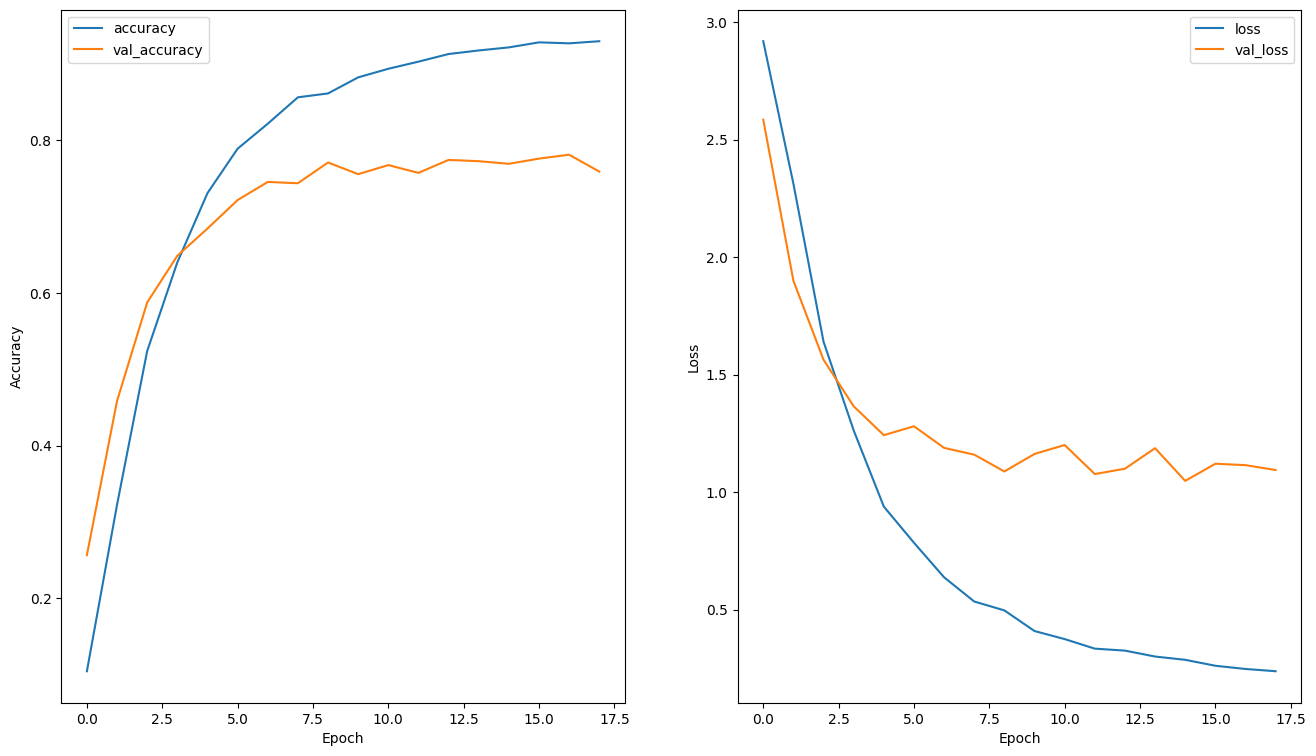

In [10]:
plt.figure(figsize=(16, 9))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.show()

In [11]:
model.save("CNN_model.h5")